# Project 5 - Vehicle Detection
## written by Moshe Roth

# imports

In [1]:
import numpy as np
import cv2
import glob
import collections
import matplotlib.pyplot as plt    # 2D plotting
import matplotlib.image as mpimg

# Interactive plotting in separate window
#%matplotlib qt
# Visualizations will be shown in the notebook
%matplotlib inline

# Helper functions

In [2]:
def plot_2_images(img1, img2, label_1, label_2, graysc=True):
    # Plot the result (1 row with 2 images)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    f.tight_layout()
    if graysc:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(label_1, fontsize=16)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(label_2, fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Template Matching 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('bbox-example-image.jpg')
#image = mpimg.imread('temp-matching-example-2.jpg')
templist = ['cutout1.jpg', 'cutout2.jpg', 'cutout3.jpg',
            'cutout4.jpg', 'cutout5.jpg', 'cutout6.jpg']

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates
def find_matches(img, template_list):
    # Make a copy of the image to draw on
    # Define an empty list to take bbox coords
    bbox_list = []
    # Iterate through template list
    # Read in templates one by one
    # Use cv2.matchTemplate() to search the image
    #     using whichever of the OpenCV search methods you prefer
    # Use cv2.minMaxLoc() to extract the location of the best match
    # Determine bounding box corners for the match
    # Return the list of bounding boxes

    method = cv2.TM_CCOEFF
    for template_filename in template_list:
        
        """
        Template Matching is a method for searching and finding the location of a 
        template image in a larger image. OpenCV comes with a function cv2.matchTemplate() 
        for this purpose. It simply slides the template image over the input image (as in 2D convolution) 
        and compares the template and patch of input image under the template image. 
        """
        template = mpimg.imread(template_filename)
        c, w, h = template.shape[::-1]
        res = cv2.matchTemplate(img,template,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        bbox_list.append((top_left, bottom_right))
    return bbox_list

bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)
plt.imshow(result)

IOError: [Errno 2] No such file or directory: 'bbox-example-image.jpg'

# Color histograms

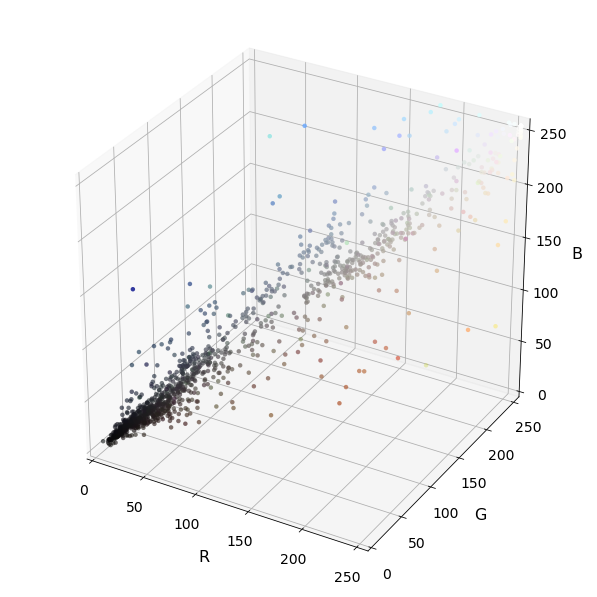

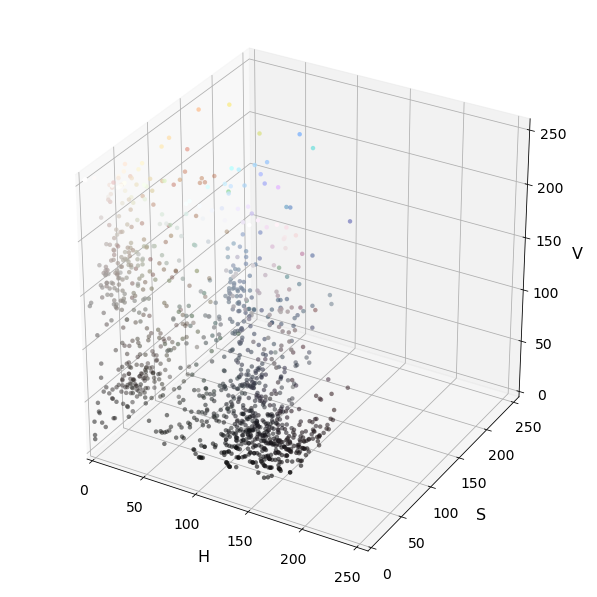

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cv2.imread("000528.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

# Run the pipeline on a test image

In [15]:
def pipeline(image):

    # Undistort image
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Threshold image
    thresholded = threshold(undistorted, do_plot = False)
    
    # Warp image
    warped = convert_perspective(thresholded, do_plot = False)
    
    # Detect lane lines
    out_img, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx = detect_lines(
        warped,
        do_plot = False)

    # Radius of curvature for left and right lines
    left_curverad, right_curverad, lane_deviation = rad_and_offset(ploty, leftx, lefty, rightx, 
                                                                   righty, left_fit, right_fit)
    # Draw output
    proc_img = draw(warped, 
                    undistorted, 
                    out_img, 
                    ploty, 
                    left_fitx, 
                    right_fitx, 
                    left_curverad, 
                    right_curverad, 
                    lane_deviation)
    return proc_img

In [16]:
left_line = Line()
right_line = Line()
image = mpimg.imread('test_images/test4.jpg')
image = pipeline(image)


# Apply Advanced Lane Detection on our video

In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
left_line = Line()
right_line = Line()
output_video = 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(pipeline)
%time video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [03:38<00:00,  5.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 3min 22s, sys: 54.9 s, total: 4min 17s
Wall time: 3min 39s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))